In [209]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')
from utils import *
import pickle
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load file containing candidate -> corpus mapping :

In [210]:
f = open("../communities/v1/candidate_to_tweets", "rb")
candidate_to_tweets = pickle.load(f)
f.close()

In [211]:
candidates_mapping = {
    0 : "Arthaud",
    1 : "Asselineau",
    2 : "Cheminade",
    3 : "Dupont-Aignan",
    4 : "Fillon",
    5 : "Hamon",
    6 : "Lassalle",
    7 : "Le Pen",
    8 : "Macron",
    9 : "Mélenchon",
    10 : "Poutou"
}

In [212]:
for cand in candidate_to_tweets.keys():
    print("{} ({}) - nombre de tweets : {}".format(candidates_mapping[cand], cand, \
                                              len(candidate_to_tweets[cand][0])))

Macron (8) - nombre de tweets : 4475
Mélenchon (9) - nombre de tweets : 5198
Fillon (4) - nombre de tweets : 2979
Hamon (5) - nombre de tweets : 2634
Le Pen (7) - nombre de tweets : 3060


In [223]:
for candidate, data in candidate_to_tweets.items():
    n_positive = len(np.argwhere(data[1] == 1))
    n_negative = len(np.argwhere(data[1] == -1))
    total = n_positive + n_negative
    print("% of positive tweets in {}'s community : {}".format(candidates_mapping[candidate], 100 * n_positive/total))

% of positive tweets in Macron's community : 41.13966480446928
% of positive tweets in Mélenchon's community : 53.46287033474413
% of positive tweets in Fillon's community : 46.69352131587781
% of positive tweets in Hamon's community : 53.49278663629461
% of positive tweets in Le Pen's community : 31.535947712418302


In [224]:
for candidate, data in candidate_to_tweets.items():
    print(">>> Communauté {}".format(candidates_mapping[candidate]))
    tweets = data[0]
    sentiments = data[1]
    ind = np.random.choice(range(0,len(tweets)), 5, replace=False)
    sample_tweets = tweets[ind]
    sample_sent = sentiments[ind]
    for i in range(5):
        print("\t{} \n\t-> {}".format(sample_tweets[i], int(sample_sent[i])))
    print("-------------------------------")

>>> Communauté Macron
	Quand #macron conscient de la radicalité de #MohamedSaou se couche devant @ccif pour acheter vote communautaire. in… https://t.co/arfeWJnhzP 
	-> 1
	L'heure est au rassemblement et à la mobilisation générale avec François Fillon. https://t.co/fPyHVrCb3D 
	-> -1
	Emmanuel Macron «passe» 6 millions de coups de téléphone pour démarcher des électeurs https://t.co/8xZaRL9t4r via @leParisien_pol 
	-> 1
	Constituante, 40 occurrences depuis le 30 janv. Toutes prononcées par #Melenchon #LePoidsDesMots… https://t.co/FZCqdz2leG 
	-> -1
	Video: Fillon s’en prend à Ruth Elkrief « Vous manquez pas d’air » https://t.co/G9OhoLr8m3 via @AssoUPF 
	-> -1
-------------------------------
>>> Communauté Mélenchon
	Coucou @MartinPersil vos plats vegan et vos gâteaux sont délicieux ! Parfaits avant un beau meeting ?? #JLMToulouse https://t.co/JL0cfmNYR4 
	-> 1
	Emmanuel Macron dit n’avoir qu’en faire du soutien de Hollande https://t.co/3BU9ranXcE https://t.co/Kf3JloyUna 
	-> -1
	EN DIRE

In [233]:
corpus = []
labels = []
for cand, data in candidate_to_tweets.items():
    tweets = data[0]
    sentiments = data[1]
    corpus = np.append(corpus, tweets)
    labels = np.append(labels, sentiments)

In [234]:
len(corpus)

18346

In [235]:
corpus, ind, unique_counts = np.unique(corpus, return_index=True, return_counts=True)

In [236]:
len(corpus)

18246

In [237]:
labels = labels[ind]

In [238]:
# ratio positif sur négatif
np.count_nonzero(labels == 1) / np.count_nonzero(labels == -1)

0.8454536259735006

In [239]:
[vectorizer, X] = build_vectorizer(corpus,\
                                     stopwords=french_stopwords(),\
                                     b_stemming=True,\
                                     b_rmaccent=True,\
                                     b_lowercase=True,
                                    b_rmnumbers=True)

Removing numbers
Removing stopwords
Stemming
Removing uppercases
Removing accents


In [240]:
words_freq = get_words_freq(vectorizer,X)

In [241]:
pd.DataFrame(words_freq).head(10)

,0,1
0,macron,5835
1,melenchon,4370
2,fillon,3755
3,hamon,1875
4,vot,1665
5,franc,1249
6,vi,1214
7,plus,991
8,jlm2017,974
9,fait,812


In [242]:
# pour vérifier à l'oeil
tweets_test = np.array(["Emmanuel #Macron l'escroquerie en marche", 
                "@FrancoisFillon Achetez-vous un parachute M. Fillon",
                "'La vie d'un entrepreneur est souvent plus difficile que celle d'un salarié'-Macron",
                "mdr le papillon dans fantasy life j'ai cru il s'appelait fillon",
                "La révolution citoyenne est train de se produire ! #Melenchon2017",
                "#JeVoteMacron 10 raisons de voter Macron ! #EnMarche #Macron2017 #Presidentielle2017",
                "#JeVotePour #Hamon2017 #BenoitHamon2017 le candidat de la jeunesse",
                "La #jeunesse : vous aurez un avenir avec @FrancoisFillon . #Fillon2017 #JeVoteFillon",
                "Arrêtons le massacre des artisans par les taxes, tous avec Marine @MLP_officiel #Marine2017",
                "@BFMTV macron ferme la ! tu tacles le Fn mais tu es 1salopard corrompu Les français s'en rendront compte vermine",
                "REPUGNANT ! MELENCHON EMBRASSE CHAVEZ ! Nous allons cracher du sang si MELENCHON est élu !",
                "Quand Marine rêve son Monde #Marine2017 ! il y a des rires glaçants, des coups sanglants et un peuple réduit à néant",
                "@FrancoisFillon La seule question qu’on doit vous poser c’est : QUAND EST CE QUE VOUS NE MENTEZ PAS ??!!",
                "#Hamon2017 Désigner un frondeur pour rassembler la gauche ? Une erreur de casting #macron2017 #Presidentielle2017"])

X_test2 = vectorize_docs(vectorizer, tweets_test)

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3,random_state=0,stratify=labels)

In [244]:
n_C = 100
interval = np.logspace(-5, 5, n_C)

mean_scores = []
for C in interval:
    clf = LinearSVC(C=C)
    scores = cross_val_score(clf, X_train, y_train, cv=4,scoring='f1')
    mean_scores.append(np.mean(scores)) 

/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to conver

/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/lauranguyen/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to conver

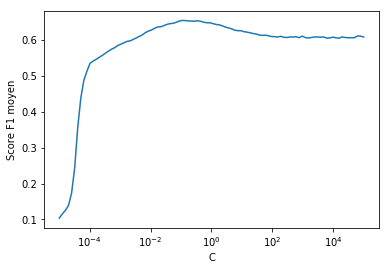

In [245]:
ax = plt.gca()

ax.plot(interval, mean_scores)
ax.set_xscale('log')
plt.xlabel('C')
plt.ylabel('Score F1 moyen')
plt.axis('tight')
plt.show()

In [246]:
C_opt = interval[np.argmax(mean_scores)]
clf = LinearSVC(C=C_opt)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
f1_score(y_test,y_pred,pos_label=1)

0.65587044534412964

In [247]:
ind_neg = np.argsort(clf.coef_).flatten()[0:10]
ind_pos = np.argsort(clf.coef_).flatten()[clf.coef_.shape[1]-10:]
print(list(np.array(vectorizer.get_feature_names())[ind_neg]))
print(list(np.array(vectorizer.get_feature_names())[ind_pos]))

['dupontaignan', 'clairock', 'feedly', 'fillonpresident', 'scolair', 'jevotefillondeslepremiertour', 'erichacquemand', 'jacqu', 'stopmelenchon', 'benoît']
['jlmtoulous', 'franceinsoumis', 'bisounour', 'corrompu', 'marineàpar', 'manson_fx', 'ptit', 'emmanuelholland', 'hamon2017', 'stopmacron']


In [248]:
clf.predict(X_test2)

array([-1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.])